In [134]:
#Necesary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import cvlib
import joblib

def extent(cnt):
    """ Receives the dims of a contour and returns its values
        
    Args:
        cnt (np array): The contour

    Returns:
        res (np array): The dimentions
    """

    area = cv.contourArea(cnt)
    x,y,w,h = cv.boundingRect(cnt)
    rect_area = w*h
    res = float(area)/rect_area
    return res

plt.style.use(['dark_background'])
%matplotlib inline

### Preparation of the plate

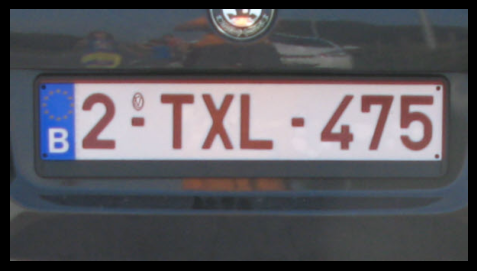

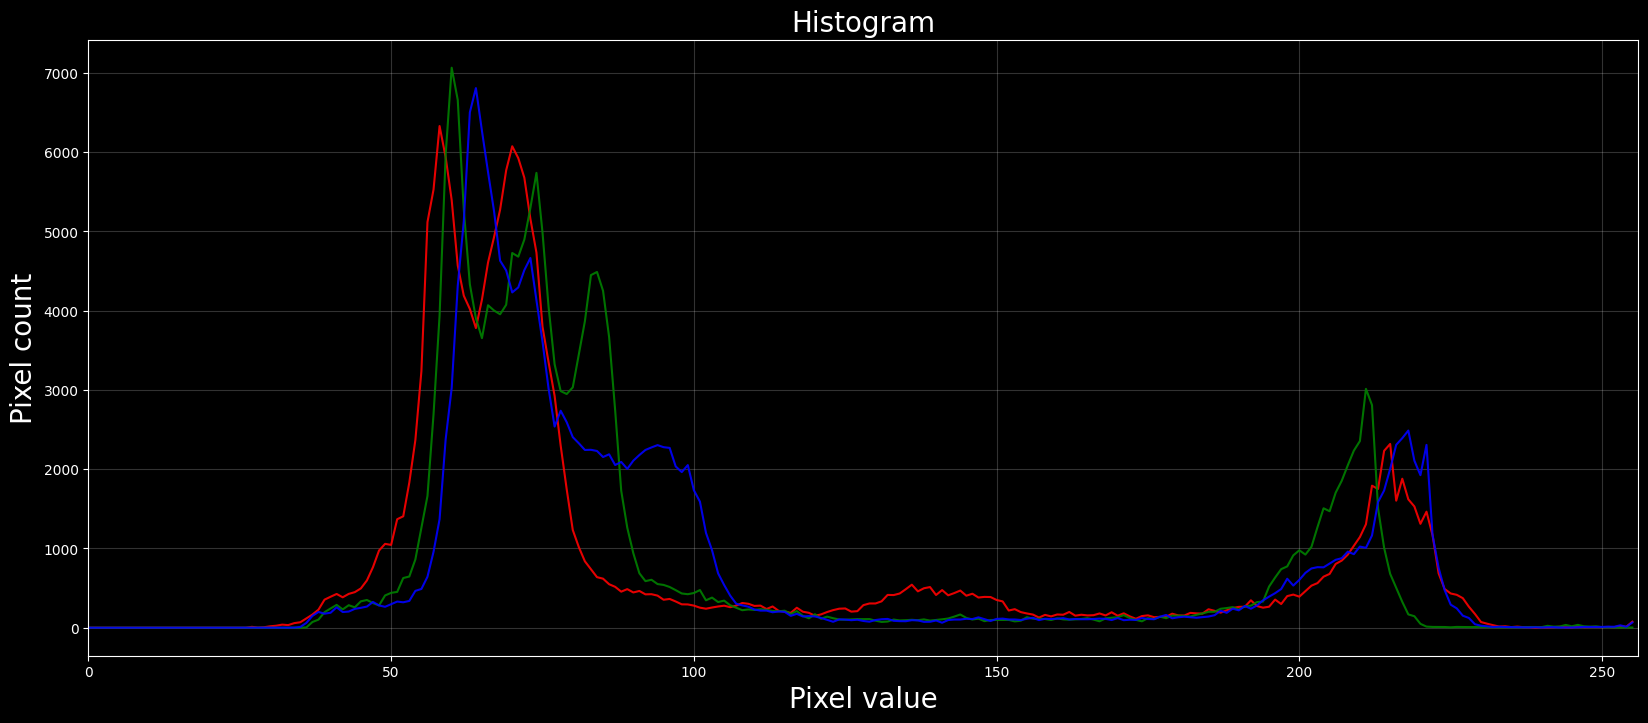

In [237]:
img_raw = cv.imread('LicencePlates/images85.jpg', cv.IMREAD_COLOR)
img_raw = cv.cvtColor(img_raw, cv.COLOR_BGR2RGB)
cvlib.imgview(img_raw)
cvlib.colorhist(img_raw)

In [238]:
# Variances expresed in the prev graf to get the lowest
red = np.var(img_raw[:,:,0])
green = np.var(img_raw[:,:,1])
blue = np.var(img_raw[:,:,2])

if blue < green and blue < red:
    imgray = img_raw[:,:,2]
elif green < blue and green < red:
    imgray = img_raw[:,:,1]
else:
    imgray = img_raw[:,:,0]

In [239]:
# Normalization of the image
_, imgray = cv.threshold(imgray, 210, 255,cv.THRESH_TRUNC)
_, imgray = cv.threshold(imgray, 60, 255,cv.THRESH_TOZERO)
imgray = cv.GaussianBlur(imgray, (5,5), 10)

In [240]:
# Getting the contours
thresh = cv.adaptiveThreshold(imgray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,17,1)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
print("# Objects:", len(contours))

# Objects: 932


In [241]:
# Getting the plate searching the most rectangular one
img = img_raw.copy() 
m, n = 0, 0
for i, contorn in enumerate(contours):
    ext = extent(contorn)
    ext = round(ext, 2)
    x,y,w,h = cv.boundingRect(contorn)
    img = cv.drawContours(img,[contorn],0,(0,255,0),2)
    img = cv.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
    if (ext > m):
        n = i 
        m = ext

In [242]:
# Plate identified
x, y, w, h = cv.boundingRect(contours[n])
xp, yp = x, y
objective = img_raw[y:y+h, x:x+w]
cv.rectangle(img_raw, (x, y), (x + w, y + h), (0, 255, 0), 4)
print(objective.shape)

(106, 488, 3)


### Extracting all the components in the plate

In [243]:
# Mapping the plate and getting shapes
h, w, _ = objective.shape
c_w = int(0.04 * w)
c_h = int(0.11 * h)
x1 = c_w
y1 = c_h
x2 = w - c_w
y2 = h - c_h
img = objective[y1:y2, x1:x2]

In [244]:
# Getting the original picture with the new coordinates
plate = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plate = cv.GaussianBlur(plate, (7,7), 1)
hist = cv.calcHist([plate], [0], None, [256], [0, 256])

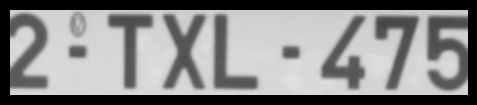

In [245]:
cvlib.imgview(plate)

In [246]:
# Binarizing
glow = sum(hist[100:])
threshold = 0.5
if glow / sum(hist) > threshold:
    img_bin = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 33, 5)
else:
    img_bin = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 23, -2)

In [247]:
# Cleaning the new image
kernel = np.ones((3, 3), np.uint8)
img_bin = cv.erode(img_bin, kernel, iterations=1)
components = cv.connectedComponentsWithStats(img_bin, connectivity=4)

In [248]:
# Getting the contours of all the elements
final = img.copy()
contours = []
w_med = []
h_med = []

for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    contours.append(area)
    
mindex = np.argmax(contours)
mvalue = contours[mindex] * 0.10

In [249]:
# Getting all the contours in the cutted image
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            w_med.append(w)
            h_med.append(h)

if len(h_med) != 0:
    max_height = (sum(h_med)/len(h_med)) * 1.40
    min_height = (sum(h_med)/len(h_med)) * 0.75
else:
    max_height = plate.shape[0]
    min_height = 0

In [250]:
components[2]

array([[    0,     0,   450,    84, 29696],
       [   60,     4,    14,    23,   139],
       [    0,     5,    36,    72,  1191],
       [   97,     6,    43,    71,   988],
       [  151,     6,    41,    72,  1121],
       [  201,     6,    42,    71,   992],
       [  307,     7,    41,    71,   961],
       [  360,     8,    41,    70,  1006],
       [  411,     8,    39,    71,  1391],
       [   59,    37,    16,    10,   152],
       [  268,    37,    16,    11,   163]], dtype=int32)

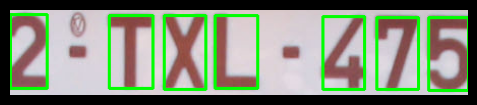

In [251]:
# Identifying the letters in the plate
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                cv.rectangle(final, (x, y), (x + w, y + h), (0, 255, 0), 2)

cvlib.imgview(final)

### Getting the digits of the plate

In [252]:
# Putting the letters in black and everything else in white
glow = sum(hist[100:])
threshold = 0.5
if glow / sum(hist) > threshold:
    img_bin2 = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 33, 5)
else:
    img_bin2 = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 23, -2)

In [253]:
# Getting the position of the letters
letters = []
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                letters.append([x, y, w, h, area])

In [254]:
letters

[[0, 5, 36, 72, 1191],
 [97, 6, 43, 71, 988],
 [151, 6, 41, 72, 1121],
 [201, 6, 42, 71, 992],
 [307, 7, 41, 71, 961],
 [360, 8, 41, 70, 1006],
 [411, 8, 39, 71, 1391]]

In [255]:
# Ordering the letters
letters_ordered = []
temp = []

for i in range(len(letters)+1):
    if i == len(letters):
        sorter = lambda x: (x[0])
        temp = sorted(temp, key=sorter)
        for j in range(len(temp)):
            letters_ordered.append(temp[j])
    else:
        if len(temp) == 0:
            temp.append(letters[i])
        else:
            if (letters[i][1] - letters[i-1][1]) < 10:
                temp.append(letters[i])
            else:
                sorter = lambda x: (x[0])
                temp = sorted(temp, key=sorter)
                for j in range(len(temp)):
                    letters_ordered.append(temp[j])
                temp = []
                temp.append(letters[i])

In [256]:
letters_ordered

[[0, 5, 36, 72, 1191],
 [97, 6, 43, 71, 988],
 [151, 6, 41, 72, 1121],
 [201, 6, 42, 71, 992],
 [307, 7, 41, 71, 961],
 [360, 8, 41, 70, 1006],
 [411, 8, 39, 71, 1391]]

In [257]:
# Removing elements that are not letters but the cutter told that they are

ared = []
ablue = []
agreen = []
for i in range(len(letters_ordered)):
    x, y, w, h, area = letters_ordered[i]
    red = np.var(img[y:y+h, x:x+w][:,:,0])
    green = np.var(img[y:y+h, x:x+w][:,:,1])
    blue = np.var(img[y:y+h, x:x+w][:,:,2])
    if blue < green and blue < red:
        ablue.append(letters_ordered[i])
    elif green < blue and green < red:
        agreen.append(letters_ordered[i])
    else:
        ared.append(letters_ordered[i])

if len(ablue) == 1:
    letters_ordered.remove(ablue[0])
if len(ared) == 1:
    letters_ordered.remove(ared[0])
if len(agreen) == 1:
    letters_ordered.remove(agreen[0])

In [258]:
# Saving the letters for identification
letters = []
for i in range(len(letters_ordered)):
    x, y, w, h, area = letters_ordered[i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                letra = img_bin2[y:y+h, x:x+w]
                letra = np.pad(letra, 5, 'constant', constant_values=255)
                new_size = cv.resize(letra, dsize=(75, 100), interpolation=cv.INTER_LANCZOS4)
                flatted = new_size.flatten()
                letters.append(flatted)

In [259]:
# Using the model to make the prediction
model = joblib.load("model.sav")
placa = ""

letra = model.predict(letters)
for i in range(len(letra)):
    placa = placa + letra[i]

### Final result

In [260]:
font = cv.FONT_HERSHEY_SIMPLEX
org = (xp,yp - 5)
fontScale = 1
color = (0, 255, 0)
thickness = 2

entregable = cv.putText(img_raw, placa, org, font, 
                   fontScale, color, thickness, cv.LINE_AA)

Placa: 2TXL475


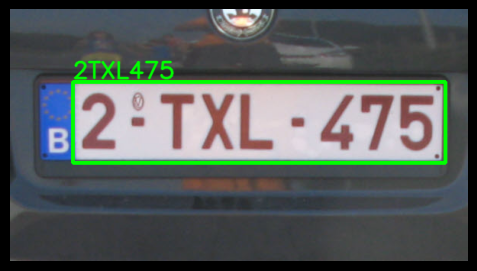

In [261]:
cvlib.imgview(entregable)
print(f"Placa: {placa}")